 <font color=steel size=6 face=雅黑>**`Towards Perturbation Theory Methods on a Quantum Computer`**</font>


## 项目介绍


微扰理论（PT）可能是物理学家和化学家最强大和富有成果的工具之一，随着原子和亚原子物理学的蓬勃发展，它引发了应用的爆炸。尽管PT在今天被广泛使用，但PT技术在量子计算中明显缺乏。在此，本文提出了一个用PT方法同时估计能量和本征态修正的量子电路，在估计二阶能量修正时，该方法远远优于经典版本。该方法在扩展Hubbard模型上的应用，并给出了数值仿真。与现行的量子变分电路不同，电路中没有对变分线路的训练或优化过程，所有的参数都是由未扰动的哈密顿量导出的。这项工作为研究具有量子器件的复杂系统提供了一种新的方法，有助于阐明基于PT的更复杂的方法的量子实现。

这篇论文利用量子线路模拟经典的微扰公式，计算哈密顿量在微扰下的一阶能量修正和二阶能量修正，以及一阶本征态修正。


## 主要结果

<font color=red size=4 face=雅黑>1.微扰理论：</font>
考虑哈密顿量：<br>$H=H_0+\lambda V$<br>其中$H_0$表示初始哈密顿量，而$V$表示不含时扰动，其中$\lambda $远远小于1.
用$|\psi_n^0\rangle$与$E_n^0$表示$H_0$的能量本征值与本征态，基于不含时微扰公式，有<br>
$E_n=E_n^0+\lambda E_n^1+\lambda^2 E_n^2+O(\lambda^3)$
<p>$|\psi_n\rangle=|\psi_n^0\rangle+\lambda |\psi_n^1\rangle+O(\lambda^2)$
<p>由此可以得到本征值和本征态的一阶修正：
<p>$ E_n^1=\langle \psi_n^0|V|\psi_n^0\rangle$
<p>$|\psi_n^1\rangle=\Sigma_{m\ne n}\frac{\langle \psi_m^0|V|\psi_n^0\rangle}{E_n^0-E_m^0}|\psi_m^0\rangle$
<p>以及本征值的二阶修正：
    <p>$E_n^2=\Sigma_{m\ne n}\frac{|\langle \psi_m^0|V|\psi_n^0\rangle|^2}{E_n^0-E_m^0}$
<p><font color=red size=4 face=雅黑>2.量子线路：</font>现在设计量子线路来计算这些量，如下图所示：
    




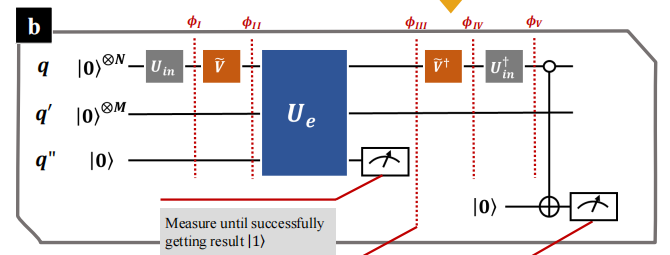

假设$H_0$是$2^N$阶方阵，在复现过程中，因为MindQuantum的门种类丰富，并不需要$q'$位置的辅助量子比特。所以在复现过程中，只用到了N+1个量子比特。
<br>线路$U_{in}$由一些X门构成，其作用是将q位置的量子比特从初始的$|0\rangle$转换为$|k\rangle$，表示我们将研究第k个本征值与本征态的微扰修正。
<br>线路$\tilde{V}$的作用是实施扰动V的作用。它由三部分组成，如图所示：

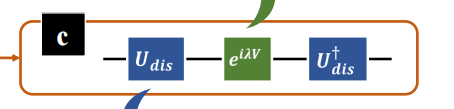

即$\tilde{V}=U_{dis}^\dagger e^{i\lambda V} U_{dis}$
<br>这里，$U_{dis}$是将计算基底转换为$H_0$的本征基底。由于量子线路的作用都是酉的，而V是一个厄密矩阵，所以实际采用$e^{i\lambda V}=I+i\lambda V+O(\lambda^2)$来近似。最后经过$U_{dis}^\dagger$将本征基底转换回计算基底。
经过上述线路后，量子态为$\Sigma_{m}\langle \psi_0^m|e^{i\lambda V}|\psi_0^k\rangle |m\rangle_q\otimes |0\rangle_{q''}$。

$U_e$线路则实现如下功能：

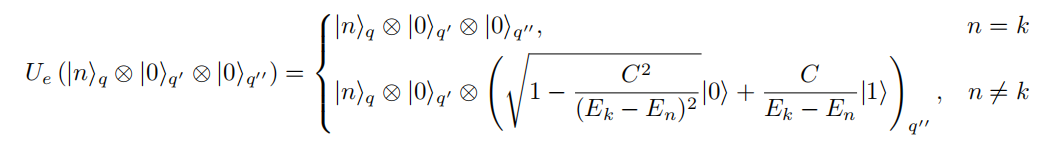

通过作用$U_e$，并对辅助比特$q''$进行测量，当结果为1时，说明量子态已塌缩至
$\Sigma_{m\ne k}C'\frac{\langle \psi_m^0|e^{i\lambda V}|\psi_n^0\rangle}{E_k^0-E_m^0}|m\rangle_q\otimes |1\rangle_{q''}$，这里$C'$是归一化因子。

<font color=red size=4 face=雅黑>3.具体模型实现：</font>该论文将这种方法应用在了扩展Hubbard模型上，即考虑一个双点费米Hubbard模型：

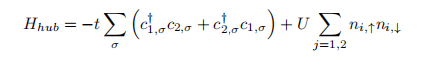

考虑微扰后，为：

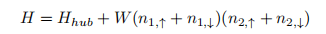

简单起见，假设$t=U=1$。因为模型考虑两个点位，每个位置有两种自旋，所以量子线路的q含有4个量子比特，从0至3依次表示$(1,\uparrow),(2,\uparrow),(1,\downarrow),(2,\downarrow)$

（1）导入库及函数

In [1]:
import numpy as np 
import scipy
import scipy.io as sio
import os
import matplotlib.pyplot as plt
import mindspore as ms
from mindquantum.core.gates import X, Y, Z, RX, RY, RZ, H
from mindquantum.core.circuit import Circuit,UN
from mindquantum.simulator import inner_product, Simulator
from mindquantum.core.gates import Measure
from mindquantum.core.operators import Hamiltonian    
from mindquantum.core.operators import QubitOperator 
from numpy import arcsin

（2）设定一些会用到的常量，其中导入的矩阵文件n_17是相应的初始哈密顿量及扰动所对应的矩阵，alpha是文中下式

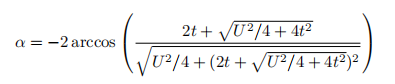

cor_theta是为了实现$U_{dis}$功能额外增加的一段线路中的参数。
<p>thetags,thetam1,theta0,theta1,theta1及thetah是$U_e$线路涉及的参数。
<p>C是线路Ue所需要的参数。

In [2]:
#代码中的一些常数
alpha=-0.24497866312686586;
cor_theta=2.7741246588994954;
data0 = sio.loadmat(os.getcwd()+'/n_17.mat');
H0=data0['A'];
e0,v0=np.linalg.eig(H0);
Vex=data0['B'];
#H1=np.zeros([16,16],float);
#H1=H0+lambda*Vex;
#e,v=np.linalg.eig(H1);
Egs=np.min(e0);
Em1=-1;
E0=0;
E1=1;
E2=2;
Eh=np.max(e0);
C=Em1-Egs;
theta0=2*arcsin(C/(E0-Egs));
theta2=2*arcsin(C/(E2-Egs))-theta0;
thetags=-theta0-theta2;
thetam1=2*arcsin(C/(Em1-Egs))-theta0;
theta1=2*arcsin(C/(E1-Egs))-theta0;
thetah=2*arcsin(C/(Eh-Egs))-theta0-thetam1;

In [3]:
#拓展控制量子门的功能
def CnX( pos, set0 , set1=-1 ):
    c=Circuit()    
    c+=UN(X,set0)
    set2=set({})
    if isinstance (set0,set):
        set2.update(set0)
    else :
        set2.add(set0)
    if set1!=-1:        
        if isinstance (set1,set):
            set2.update(set1)
        else :
            set2.add(set1)
    c+=X(pos,set2)
    c+=UN(X,set0)
    return c

In [4]:
#为了简化Udis的搭建，定义如下需要的函数
def RY_m_n1(switchs, para,n,num_q):
    c = Circuit()
    length=len(switchs)
    i=0
    while i<length:
        x=switchs[i][0]
        y=switchs[i][1]
        if y==0:
            c+=CnX(set0={n},pos=x)
        else :
            c+=X(x,n)
        i=i+1
    qub=set(range(num_q))
    qub.remove(n)
    c+=X(n,qub)
    c+=RY(-para).on(n)
    c+=X(n,qub)
    c+=RY(para).on(n)
    c+=X(n,qub)
    i=i-1
    while i>=0:
        x=switchs[i][0]
        y=switchs[i][1]
        if y==0:
            c+=CnX(set0={n},pos=x)
        else :
            c+=X(x,n)
        i=i-1
    return c
def RY_m_n2(switchs, para,n,num_q,dag=False):
    c = Circuit()
    length=len(switchs)
    i=0
    while i<length:
        x=switchs[i][0]
        y=switchs[i][1]
        if y==0:
            c+=CnX(set0={n},pos=x)
        else :
            c+=X(x,n)
        i=i+1
    qub=set(range(num_q))
    qub.remove(n)
    c+=UN(X,qub)
    if not dag:
        c+=X(n,qub)
    c+=RY(-para).on(n)
    c+=X(n,qub)
    c+=RY(para).on(n)
    if dag:
        c+=X(n,qub)
    c+=UN(X,qub)
    i=i-1
    while i>=0:
        x=switchs[i][0]
        y=switchs[i][1]
        if y==0:
            c+=CnX(set0={n},pos=x)
        else :
            c+=X(x,n)
        i=i-1
    return c
def F(m,n,dag=False):
    c=Circuit()
    if dag:
        c+=Z(n,m)
    c+=X(n,m)
    c+=H(m,n)
    c+=X(n,m)
    if not dag:
        c+=Z(n,m)
    return c

In [5]:
#Udis 线路
Udis=Circuit()
Udis+=RY_m_n2([[1,1],[2,1],[3,1]],cor_theta,0,4)
Udis+=UN(X,{0,2})
Udis+=RY_m_n1([[1,1],[2,1],[0,0]],np.pi/4,3,4)
Udis+=RY_m_n1([[1,0],[2,1],[0,1]],-alpha,3,4)
Udis+=F(0,1)
Udis+=F(2,3)

############Udis_dag 线路
Udis_dag=Circuit();
Udis_dag+=F(0,1,dag=True)
Udis_dag+=F(2,3,dag=True)
Udis_dag+=RY_m_n1([[1,0],[2,1],[0,1]],-alpha,3,4)
Udis_dag+=RY_m_n1([[1,1],[2,1],[0,0]],np.pi/4,3,4)
Udis_dag+=UN(X,{0,2})
Udis_dag+=RY_m_n2([[1,1],[2,1],[3,1]],cor_theta,0,4,dag=True)

$e^{i\lambda V}$线路按照如下图搭建：

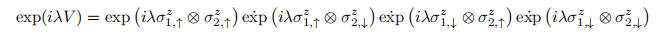

In [6]:
para_dict={}
def Exp(m,n,para_name):
    c=Circuit()
    c+=X(n,m)
    c+=RZ(para_name).on(n)
    c+=X(n,m)
    return c
#受控Exp线路需要用到的函数
def CExp(m,n,para_name,k):
    c=Circuit()
    c+=X(n,{m,k})
    c+=RZ(para_name).on(n,k)
    c+=X(n,{m,k})
    return c

In [7]:
#e^(i*lambda*V)线路,lambdam2表示-2*lambda
V=Circuit();
V+=Exp(0,1,'lambdam2')
V+=Exp(0,3,'lambdam2')
V+=Exp(1,2,'lambdam2')
V+=Exp(1,3,'lambdam2')

由于从复现的图c开始更换了拟合V作用的线路，我用Vpr来表示这一段新的线路：

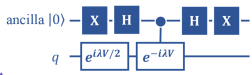

In [8]:
#exp(i lambda V/2)-exp(-i lambda V/2)线路,引入一个新的辅助比特，这里引入的辅助比特处于位置6处
Vpr=Circuit();
Vpr+=X(5);
Vpr+=H(5);
Vpr+=Exp(0,1,'lambdam')
Vpr+=Exp(0,3,'lambdam')
Vpr+=Exp(1,2,'lambdam')
Vpr+=Exp(1,3,'lambdam')
Vpr+=CExp(0,1,'lambda2',5)
Vpr+=CExp(0,3,'lambda2',5)
Vpr+=CExp(1,2,'lambda2',5)
Vpr+=CExp(1,3,'lambda2',5)
Vpr+=H(5);
Vpr+=X(5);

In [9]:
#拓展控制量子门的功能,pos是被作用的比特位，set0与set1都是控制比特，set0是空心圆，set1是实心圆
def CnY( para , pos, set0 , set1=-1 ):
    c=Circuit()    
    c+=UN(X,set0)
    set2=set({})
    if isinstance (set0,set):
        set2.update(set0)
    else :
        set2.add(set0)
    if set1!=-1:        
        if isinstance (set1,set):
            set2.update(set1)
        else :
            set2.add(set1)
    c+=RY(para).on(pos,set2)
    c+=UN(X,set0)
    return c

In [10]:
#U_e线路,相较于原文，不需要引入辅助比特q'
Ue=Circuit();
Ue+=RY(theta0).on(4)
Ue+=CnY(para=theta2, pos=4 , set0={0,2})
Ue+=CnY(para=thetags, pos=4 , set0={0,1,2,3})
Ue+=RY(thetam1).on(4,{0,2}) 
Ue+=CnY(para=-thetam1, pos=4 , set0={1,3},set1={0,2})
Ue+=RY(thetah).on(4,{0,1,2,3}) 
Ue+=CnY(para=theta1, pos=4 , set0={2,3},set1=0)
Ue+=CnY(para=theta1, pos=4 , set0={0,1,3},set1=2)

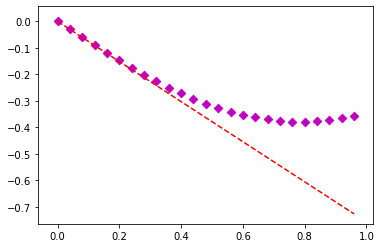

In [11]:
####图3a)，一阶能量修正，与经典算法作比较
_lambda=0.0;
Fst_energy=np.array([]);
list_of_lambda=np.array([]);
while _lambda<1:
    bra_simulator = Simulator('projectq', 4);
    ket_simulator = Simulator('projectq', 4);
    bra_simulator.apply_circuit(Udis);
    ket_simulator.apply_circuit(Udis+V.apply_value({'lambdam': -_lambda,'lambdam2': -2*_lambda,'lambda': _lambda}));
    Fst_energy=np.append(Fst_energy,inner_product(bra_simulator, ket_simulator).imag);
    list_of_lambda=np.append(list_of_lambda,_lambda);
    _lambda+=0.04;
plt.scatter(list_of_lambda,Fst_energy,c='m',marker='D');

Vpert=QubitOperator('Z0 Z1')+QubitOperator('Z0 Z3')+QubitOperator('Z1 Z2')+QubitOperator('Z1 Z3');
Vpert=Hamiltonian(Vpert);
pur_simulator = Simulator('projectq', 4);
pur_simulator.apply_circuit(Udis);
_y=(pur_simulator.get_expectation(Vpert)).real*list_of_lambda;
plt.plot(list_of_lambda,_y,'--',color='r')

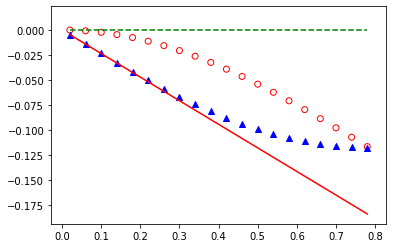

In [12]:
####图3b)，一阶本征态修正，与经典算法作比较
_lambda=0.02;
Fst_eig_real=np.array([]);
Fst_eig_imag=np.array([]);
list_of_lambda=np.array([]);
while _lambda<0.8:
    sim1=Simulator('projectq', 5);
    sim1.apply_circuit(Udis+V.apply_value({'lambdam': -_lambda,'lambdam2': -2*_lambda,'lambda2': 2*_lambda})+Udis_dag+Ue);
    state1=sim1.get_qs();
    prj1=0.5*QubitOperator('Z4')+0.5*QubitOperator('');
    prj1=Hamiltonian(prj1);
    prob1=1-sim1.get_expectation(prj1);
    Cprm=C/np.power(prob1,0.5);
    cir_meas1=Circuit();
    cir_meas1+=Measure().on(4);
    while True :
        sim1=Simulator('projectq', 5);
        sim1.set_qs(state1);
        sim1.apply_circuit(cir_meas1);
        res=sim1.get_expectation(prj1)
        if res.real<0.1:
            break
    phi=sim1.get_qs()/Cprm;
    Fst_eig_real=np.append(Fst_eig_real,phi[31].real);
    Fst_eig_imag=np.append(Fst_eig_imag,phi[31].imag);
    list_of_lambda=np.append(list_of_lambda,_lambda);
    _lambda+=0.04;
plt.scatter(list_of_lambda,Fst_eig_real,c='',marker='o',edgecolors='r');
plt.scatter(list_of_lambda,Fst_eig_imag,c='b',marker='^');

pert_sim=Simulator('projectq', 4);
pert_sim.apply_circuit(Udis);
phi_gs=pert_sim.get_qs();
pert_sim=Simulator('projectq', 4);
pert_sim.apply_gate(X(0));
pert_sim.apply_gate(X(1));
pert_sim.apply_gate(X(2));
pert_sim.apply_gate(X(3));
pert_sim.apply_circuit(Udis);
phi_h=pert_sim.get_qs();
cor_phi=np.dot(phi_gs,Vex);
cor_phi=np.dot(cor_phi,np.transpose(phi_h));
_y_real=cor_phi.real/(Eh-Egs)*list_of_lambda;
_y_imag=cor_phi.imag/(Eh-Egs)*list_of_lambda;
plt.plot(list_of_lambda,_y_real,color='r');
plt.plot(list_of_lambda,_y_imag,'--',color='g');

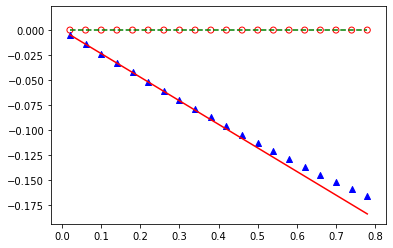

In [13]:
####图3c)，一阶本征态修正，采用改进的量子算法，与经典算法作比较
_lambda=0.02;
Fst_eig_real2=np.array([]);
Fst_eig_imag2=np.array([]);
Sec_energy=np.array([]);
list_of_lambda=np.array([]);

prj1=0.5*QubitOperator('Z4')+0.5*QubitOperator('');
prj1=Hamiltonian(prj1);
prj2=0.5*QubitOperator('Z5')+0.5*QubitOperator('');
prj2=Hamiltonian(prj2);

while _lambda<0.8:
    sim2=Simulator('projectq', 6);
    sim2.apply_circuit(Udis+Vpr.apply_value({'lambdam': -_lambda,'lambdam2': -2*_lambda,'lambda2': 2*_lambda})+Udis_dag);
    state2=sim2.get_qs();
    prob2=1-sim2.get_expectation(prj2);
    scale=np.power(prob2,0.5)*2;
    
    cir_meas1=Circuit();
    cir_meas1+=Measure().on(5);
    while True :
        sim3=Simulator('projectq', 6);
        sim3.set_qs(state2);
        sim3.apply_circuit(cir_meas1);
        res=sim3.get_expectation(prj2);    
        if  res.real<0.1:
            break
    state3=sim3.get_qs();
    sim3.apply_circuit(Ue);
    state4=sim3.get_qs();
    prob1=1-sim3.get_expectation(prj1);
    Cprm=C/np.power(prob1,0.5);
    cir_meas2=Circuit();
    cir_meas2+=Measure().on(4);
    while True :
        sim4=Simulator('projectq', 6);
        sim4.set_qs(state4);
        sim4.apply_circuit(cir_meas2);
        res=sim4.get_expectation(prj1);    
        if  res.real<0.1:
            break
    state5=sim4.get_qs();
    phi=sim4.get_qs()/Cprm*scale;
    Fst_eig_real2=np.append(Fst_eig_real2,phi[63].real);
    Fst_eig_imag2=np.append(Fst_eig_imag2,phi[63].imag);
    
    bra_simulator = Simulator('projectq', 6);
    ket_simulator = Simulator('projectq', 6);
    bra_simulator.set_qs(state3);
    ket_simulator.set_qs(state5);
    bra_simulator.apply_gate(X(4));
    cur_energy=inner_product(bra_simulator, ket_simulator)/Cprm*scale*scale;
    Sec_energy=np.append(Sec_energy,cur_energy.real);
                         
    list_of_lambda=np.append(list_of_lambda,_lambda);
    _lambda+=0.04;
plt.scatter(list_of_lambda,Fst_eig_real2,c='',marker='o',edgecolors='r');
plt.scatter(list_of_lambda,Fst_eig_imag2,c='b',marker='^');

_y_real=cor_phi.real/(Eh-Egs)*list_of_lambda;
_y_imag=cor_phi.imag/(Eh-Egs)*list_of_lambda;
plt.plot(list_of_lambda,_y_real,color='r');
plt.plot(list_of_lambda,_y_imag,'--',color='g');

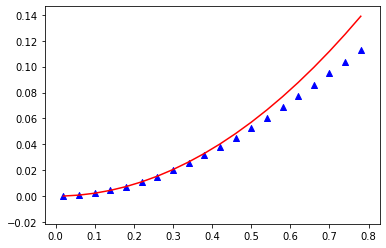

In [14]:
####图3d)，二阶能量修正，采用改进的量子算法，与经典算法作比较
plt.scatter(list_of_lambda,Sec_energy,c='b',marker='^');
_y_energy=cor_phi.real*cor_phi.real/(Eh-Egs)*list_of_lambda**2;
plt.plot(list_of_lambda,_y_energy,color='r');